# WMHpypes Quickstart

In [15]:
from IPython.display import Image

## Grab input data

In [16]:
models_dir = '../models' # Folder containing the models as .h5  
temp_dir = './tmp' # Folder for the workflow's temporary files

In [17]:
import os
from nipype.pipeline.engine import Workflow, Node
from nipype import DataGrabber, DataSink, IdentityInterface

In [18]:
#Subject IDs
import os
sub_ids = [i.strip('flair_').strip('.nii.gz') for i in os.listdir('./test_dataset/flair')]

data_source = Node(interface=IdentityInterface(fields = ['weights', 'sub-id']), name='data_source')
data_source.iterables = ('sub-id', sub_ids)

data_source.inputs.weights = [os.path.join(os.getcwd(), '../models', i) for i in os.listdir('../models')]

data_grabber = Node(interface=DataGrabber(infields=['sub-id'],
                                          outfields=['flair']), name='data_grabber')
data_grabber.inputs.base_directory = os.path.abspath('./test_dataset')
data_grabber.inputs.template = 'flair/flair_%s.nii.gz'
data_grabber.inputs.template_args = {'flair' : [['sub-id']]}
data_grabber.inputs.sort_filelist = False

## Preprocessing

We perform a minimal preprocessing comprising:
1. Brain Extraction (BET)
2. Denoising (CAT12)

For a Matlab-free version of the workflow, ANTs Denoise can be used (https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.segmentation.html#denoiseimage)

In [19]:
from nipype.interfaces import cat12
from nipype.interfaces import fsl

from wmhpypes.interfaces import misc

In [20]:
bet = Node(interface=fsl.BET(reduce_bias=True,
                             frac=.2,
                             output_type='NIFTI'), name='bet')
denoising = Node(interface=cat12.CAT12SANLMDenoising(), name='denoising')

## Segmentation

In [21]:
from wmhpypes.workflows import ibbmTum_wf

test_wf = ibbmTum_wf.get_test_wf(row_st=200,
                                     cols_st=200,
                                     thres_mask=10)

Rows and Cols can be taken from the NIfTI dimension

## Output

In [22]:
out_dir =  './out' # Folder where we want to save the outputs 

In [23]:
sink = Node(interface=DataSink(), name = 'sink')
sink.inputs.base_directory = os.path.abspath(out_dir)
sink.inputs.regexp_substitutions = [(r'\.\.(.*)\.\.', '')]

## Connecting nodes

In [24]:
wmh_wf = Workflow(name='wmhpypes_wf', base_dir=temp_dir)
wmh_wf.connect(data_source, 'sub-id', data_grabber, 'sub-id')
wmh_wf.connect(data_grabber, 'flair', bet, 'in_file')
wmh_wf.connect(bet, 'out_file', denoising, 'in_files')
wmh_wf.connect(denoising, 'out_file', test_wf, 'inputspec.flair')
wmh_wf.connect(data_source, 'weights', test_wf, 'inputspec.weights')
wmh_wf.connect(test_wf, 'outputspec.wmh_mask', sink, '@wmh_mask')

## Plot Workflow

220109-00:38:35,181 nipype.workflow INFO:
	 Generated workflow graph: ./imgs/example_wf.png (graph2use=colored, simple_form=True).


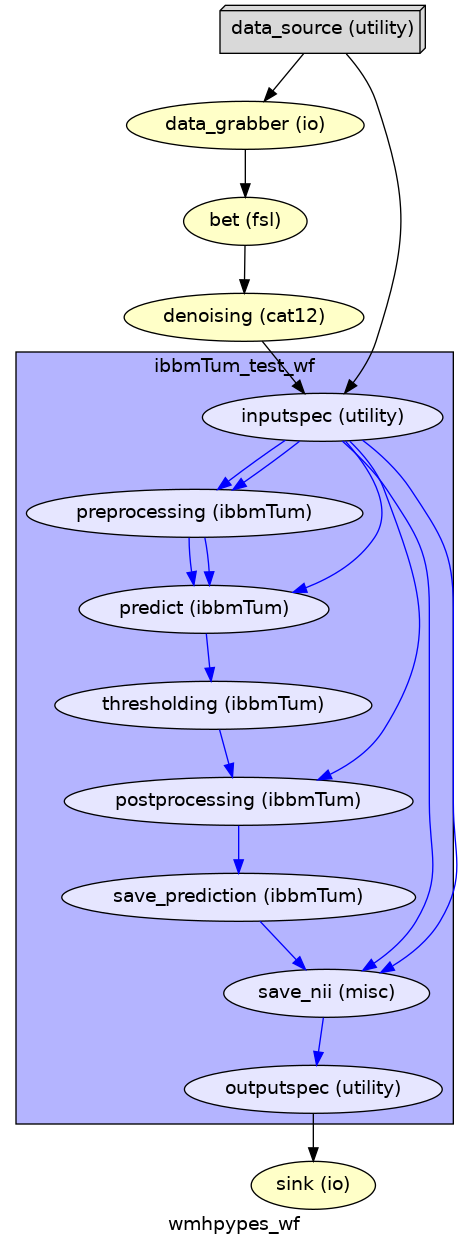

In [25]:
wmh_wf.write_graph(graph2use='colored', dotfilename='./imgs/example_wf.dot')
Image('./imgs/example_wf.png', width=300)

## Run it

In [26]:
plugin_args = {'n_procs': 5}
wmh_wf.run(plugin='MultiProc', plugin_args=plugin_args)

220109-00:38:36,468 nipype.workflow INFO:
	 Workflow wmhpypes_wf settings: ['check', 'execution', 'logging', 'monitoring']
220109-00:38:36,475 nipype.workflow INFO:
	 Running in parallel.
220109-00:38:36,477 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
220109-00:38:36,561 nipype.workflow INFO:
	 [Node] Setting-up "wmhpypes_wf.data_grabber" in "/media/orco/home_data/Dokumente/DZNE/Art2/WMHpypes/examples/tmp/wmhpypes_wf/_sub-id_00001/data_grabber".
220109-00:38:36,564 nipype.workflow INFO:
	 [Node] Executing "data_grabber" <nipype.interfaces.io.DataGrabber>
220109-00:38:36,566 nipype.workflow INFO:
	 [Node] Finished "data_grabber", elapsed time 0.00028s.
220109-00:38:38,481 nipype.workflow INFO:
	 [Job 0] Completed (wmhpypes_wf.data_grabber).
220109-00:38:38,483 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.14/28.14, Free processors: 5/5.
220109-00:38:38,572 nipype

RuntimeError: Traceback (most recent call last):
  File "/media/orco/home_data/Dokumente/DZNE/Art2/WMHpypes/.conda/envs/wmhpypes/lib/python3.9/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/media/orco/home_data/Dokumente/DZNE/Art2/WMHpypes/.conda/envs/wmhpypes/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 521, in run
    result = self._run_interface(execute=True)
  File "/media/orco/home_data/Dokumente/DZNE/Art2/WMHpypes/.conda/envs/wmhpypes/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 639, in _run_interface
    return self._run_command(execute)
  File "/media/orco/home_data/Dokumente/DZNE/Art2/WMHpypes/.conda/envs/wmhpypes/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 750, in _run_command
    raise NodeExecutionError(
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node bet.

Traceback (most recent call last):
  File "/media/orco/home_data/Dokumente/DZNE/Art2/WMHpypes/.conda/envs/wmhpypes/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/media/orco/home_data/Dokumente/DZNE/Art2/WMHpypes/.conda/envs/wmhpypes/lib/python3.9/site-packages/nipype/interfaces/fsl/preprocess.py", line 165, in _run_interface
    self.raise_exception(runtime)
  File "/media/orco/home_data/Dokumente/DZNE/Art2/WMHpypes/.conda/envs/wmhpypes/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 673, in raise_exception
    raise RuntimeError(
RuntimeError: Command:
bet flair_00001.nii.gz flair_00001_brain.nii -f 0.20 -B
Standard output:
/home/orco/Programs/fsl/bin/bet failed during command:flair_00001.nii.gz flair_00001_brain.nii -f 0.20 -B
Standard error:
/home/orco/Programs/fsl/bin/standard_space_roi: 241: /home/orco/Programs/fsl/bin/imcp: not found
/home/orco/Programs/fsl/bin/bet: line 399: 49448 Aborted                 (core dumped) ${FSLDIR}/bin/fast -b ${OUT}_tmp_premask > /dev/null 2>&1
Return code: 1



## Results

To plot the NIfTIs we will use NIlearn plotting capabilities

In [ ]:
import nilearn.plotting as plotting

#### Input file

In [ ]:
flair = './test_dataset/FLAIR.nii.gz'
out = './out/_flairs_test_flair.nii.gz/prediction.nii.gz'

In [ ]:
plotting.plot_anat(flair)

#### Result

In [ ]:
plotting.plot_roi(out, flair) #, display_mode='mosaic' )

In [ ]:
plotting.plot_anat(out)